<a href="https://colab.research.google.com/github/swicklund/hackathon/blob/main/MLModel2-2_10MinutesLater.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Model uses a Random Forest at attempt to look ahead 10 minutes (rather than 1 Mile)

In [1]:
!pip install -Uqq fastbook
import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import fastbook as fastai
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import tensorflow as tf
import json
import zipfile
from io import BytesIO
import torch
import math
from google.colab import files
from google.colab import auth
from datetime import datetime, timedelta

fastai.setup_book()
from fastai import tabular


     |████████████████████████████████| 719 kB 4.7 MB/s 
     |████████████████████████████████| 362 kB 24.3 MB/s 
     |████████████████████████████████| 1.2 MB 4.2 MB/s 
     |████████████████████████████████| 4.4 MB 10.5 MB/s 
     |████████████████████████████████| 140 kB 45.2 MB/s 
     |████████████████████████████████| 101 kB 5.0 MB/s 
     |████████████████████████████████| 212 kB 41.6 MB/s 
     |████████████████████████████████| 1.1 MB 34.9 MB/s 
     |████████████████████████████████| 596 kB 11.5 MB/s 
     |████████████████████████████████| 127 kB 47.8 MB/s 
     |████████████████████████████████| 144 kB 11.5 MB/s 
     |████████████████████████████████| 271 kB 10.5 MB/s 
     |████████████████████████████████| 94 kB 1.7 MB/s 
     |████████████████████████████████| 6.6 MB 40.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6

In [2]:
!pip install dtreeviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 180 kB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3.6-py3-none-any.whl size=67326 sha256=ef49cdb32a7e6c1e78d6cf9804c6aad190e59871a63fb4393705dc52f62e1a9f
  Stored in directory: /root/.cache/pip/wheels/33/76/fe/99227ff871766e7284bb88d3d28e2f4886b8ec04d669033478
Successfully built dtreeviz


In [3]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [4]:
auth.authenticate_user()

In [5]:
!gcloud config set project {'hackathon-352519'}

Updated property [core/project].


In [6]:
!gsutil cp gs://trains_data/* /tmp/.

Copying gs://trains_data/train-data-2022062020220626.zip...
Copying gs://trains_data/train-data_all-train-events.zip...
/ [2 files][249.3 MiB/249.3 MiB]                                                
Operation completed over 2 objects/249.3 MiB.                                    


In [7]:
trains = {}
i = 1
prevLoco = ''
with zipfile.ZipFile("/tmp/train-data_all-train-events.zip", "r") as f:
    for name in f.namelist():
        if name.endswith('.json'):
            with f.open(name) as zd:
                data = json.load(zd)
                lastTrainReporting = data['lastTrainReporting']
                currentLoco = lastTrainReporting['ptcLeadLocomotiveId']
                # Make sure there is at least ten minutes of actuals
                if ("trainActualPositionList" in lastTrainReporting and len(lastTrainReporting['trainActualPositionList']) > 4): 
                    trainActualPositionList = lastTrainReporting['trainActualPositionList']
                    trains[i] = pd.json_normalize(lastTrainReporting)
                    i = i + 1
                    if (i % 1000 == 0):
                      current_time = datetime.now().strftime("%H:%M:%S")
                      print(i, " ", current_time)
                    prevLoco = currentLoco
                            

1000   19:20:58
2000   19:21:11
3000   19:21:24
4000   19:21:30
5000   19:21:35
6000   19:21:40
7000   19:21:46
8000   19:21:52
9000   19:21:58


In [8]:
dfTrainsAll = pd.concat(trains.values())
dfTrainsAll["milepost"] = dfTrainsAll.apply(lambda row: math.trunc(row['lastReportedPosition.milepostLocation.milepost.milepostNumber']), axis=1)

In [9]:
del trains

In [10]:
print(dfTrainsAll.info())
print(dfTrainsAll.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9591 entries, 0 to 0
Data columns (total 45 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   ptcLeadLocomotiveId                                                        9591 non-null   object 
 1   maximumTrainSpeed                                                          9590 non-null   float64
 2   loadedCarCount                                                             9590 non-null   float64
 3   emptyCarCount                                                              9590 non-null   float64
 4   trainLength                                                                9590 non-null   float64
 5   trailingTonnage                                                            9590 non-null   float64
 6   positionHistoryList                                        

In [11]:
dfTrainsLearn = dfTrainsAll
dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'] = dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'].astype('category')
dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'] = dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'].cat.set_categories(['WEST MAIN', 'MAIN', 'MT 2', 'MT 1', 'WESTXO', 'XO', 'EASTXO','YD LD', 'EAST MAIN', 'TO_N_EAST MAIN', 'TO_S_UP_MAINLINE', 'TO_S_CS JUNCTION', 'S_STARKS', 'TO_S_KCS UP PRT CONN', 'TO_N_LUCAS', 'S_LUCAS'])
#dfTrainsLearn['lastReportedSpeedMPH'] = dfTrainsLearn.apply(lambda row: row['positionHistoryList'][0]['speedMPH'], axis=1)
dfTrainsLearn['symbolType'] = dfTrainsLearn.apply(lambda row: row['trainId.trainSymbol'][:1], axis=1)
dfTrainsLearn['symbolType'] = dfTrainsLearn['symbolType'].astype('category')
dfTrainsLearn['symbolType'] = dfTrainsLearn['symbolType'].cat.set_categories(['M', 'I', 'Z', 'C', 'W', 'E', 'U'])


In [12]:
def getWorkLocations(dfTrainsLocation):
  if len(dfTrainsLocation['aotuTrainData.routeLocationList']) == 0:
    return None
  aotuRoute=pd.json_normalize(dfTrainsLocation['aotuTrainData.routeLocationList']) 
  eventLocations = aotuRoute[aotuRoute['activityList'].map(len) > 1]
  temp = eventLocations['milepost.milepostNumber'].unique()
  if len(temp) == 0:
    return None
  return ','.join(['%.2f' % num for num in temp])

In [13]:
#getWorkLocations(dfTrainsLearn.iloc[301])

In [14]:
#dfTrainsLearn.loc[dfTrainsLearn['aotuTrainData.routeLocationList'].map(len)==0]

In [15]:
dfTrainsLearn['workLocations'] = dfTrainsLearn.apply(lambda row: getWorkLocations(row), axis=1)

In [16]:
dfTrainsLearn['workLocations'].unique()

array([None, '202.20', '258.40,202.20', '202.20,258.40', '202.20,258.40,321.50', '202.92,202.20', '225.10,202.20', '240.90,202.20'], dtype=object)

We can make this more clever later, but for now this seems the most sensible shortcut

In [17]:
dfTrainsLearn['locomotiveCount'] = dfTrainsLearn.apply(lambda row: len(row['locomotiveList']),axis = 1)

In [18]:
dfTrainsLearn = dfTrainsLearn.reset_index(drop=True)

In [19]:
dfTrainsLearnActuals = dfTrainsLearn.apply(lambda row: pd.json_normalize(row['trainActualPositionList']), axis=1)

In [20]:
dfTrainsLearnActuals.iloc[1]

,positionTime,speedMPH,milepostLocation.subdivisionId,milepostLocation.trackName,milepostLocation.milepost.milepostNumber
0,2022-04-21T23:34:11Z,-10,106,WEST MAIN,766.36030
1,2022-04-21T23:36:11Z,-10,106,MAIN,766.01776
2,2022-04-21T23:38:11Z,-9,106,MAIN,765.68665
3,2022-04-21T23:40:11Z,-8,106,MAIN,765.38310
4,2022-04-21T23:42:11Z,-9,106,MAIN,765.07520


In [21]:
dfTrainsLearn.iloc[1]['lastReportedPosition.speedMPH']

-11

In [22]:
def findNextSpeed(trainsEntry, actualsEntry):
  #print(actualsEntry.iloc[4]['speedMPH'], " - ",trainsEntry['lastReportedPosition.speedMPH'] )
  return (actualsEntry.iloc[4]['speedMPH'] - trainsEntry['lastReportedPosition.speedMPH'])

In [23]:
findNextSpeed(dfTrainsLearn.iloc[101], dfTrainsLearnActuals.iloc[101])

6

In [24]:
dfTrainsLearn = dfTrainsLearn.dropna(subset=['ptcLeadLocomotiveId'])
dfTrainsLearn

,ptcLeadLocomotiveId,maximumTrainSpeed,loadedCarCount,emptyCarCount,...,milepost,symbolType,workLocations,locomotiveCount
0,UP2010,50.0,61.0,92.0,...,766,M,None,2
1,UP2010,50.0,61.0,92.0,...,766,M,None,2
2,UP2524,70.0,37.0,5.0,...,326,Z,202.20,5
3,UP2524,70.0,37.0,5.0,...,325,Z,202.20,5
4,UP2524,70.0,37.0,5.0,...,323,Z,202.20,5
...,...,...,...,...,...,...,...,...,...
9586,UP6459,40.0,105.0,91.0,...,242,M,202.20,3
9587,UP6459,40.0,105.0,91.0,...,243,M,202.20,3
9588,UP6459,40.0,105.0,91.0,...,245,M,202.20,3
9589,UP6459,40.0,105.0,91.0,...,246,M,202.20,3


In [25]:
dfTrainsLearn['nextSpeed'] = dfTrainsLearn['lastReportedPosition.speedMPH']
i = 0;
for index, trainsEntry in dfTrainsLearn.iterrows():
  actualsEntry = dfTrainsLearnActuals.iloc[i]
  nextSpeed = findNextSpeed(trainsEntry, actualsEntry)
  if (nextSpeed != None):
    dfTrainsLearn.at[i,'nextSpeed'] = nextSpeed
  if (i % 1000 == 0):
    print(i)
  i = i + 1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [26]:
# dfTrainsLearn = dfTrainsLearn.drop(['hour'], axis=1)
len(dfTrainsLearn)

9591

Drop some values we are not using at the moment not needed

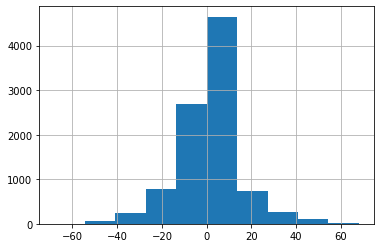

In [27]:
ax = dfTrainsLearn['nextSpeed'].hist()

In [28]:
dfTrainsLearn = dfTrainsLearn.drop(columns=['aotuTrainData.tenantCarrier',
                                            'lastReportedPosition.precedingSignalState.currentStateTime', 
                                            'lastReportedPosition.nextSignalState.previousSignalState', 
                                            'lastReportedPosition.nextSignalState.currentStateTime', 
                                            'positionHistoryList',
                                            'locomotiveList',
                                            'subdivisionList',
                                            'trainActualPositionList',
                                            'trainEstimatedPositionList',
                                            'aotuTrainData.routeLocationList'])

In [29]:
tabular.core.make_date(dfTrainsLearn, 'trainId.trainDate')
tabular.core.make_date(dfTrainsLearn, 'lastReportedPosition.positionTime')
tabular.core.add_datepart(dfTrainsLearn, 'lastReportedPosition.positionTime')
# tabular.core.add_elapsed_times(dfTrainsLearn, 'lastReportedPosition.positionTime')


,ptcLeadLocomotiveId,maximumTrainSpeed,loadedCarCount,emptyCarCount,...,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,lastReportedPosition.positionTimeElapsed
0,UP2010,50.0,61.0,92.0,...,False,False,False,1.650584e+09
1,UP2010,50.0,61.0,92.0,...,False,False,False,1.650584e+09
2,UP2524,70.0,37.0,5.0,...,False,False,False,1.649435e+09
3,UP2524,70.0,37.0,5.0,...,False,False,False,1.649435e+09
4,UP2524,70.0,37.0,5.0,...,False,False,False,1.649435e+09
...,...,...,...,...,...,...,...,...,...
9586,UP6459,40.0,105.0,91.0,...,False,False,False,1.649637e+09
9587,UP6459,40.0,105.0,91.0,...,False,False,False,1.649637e+09
9588,UP6459,40.0,105.0,91.0,...,False,False,False,1.649637e+09
9589,UP6459,40.0,105.0,91.0,...,False,False,False,1.649637e+09


In [30]:
print(dfTrainsLearn.shape)
print(dfTrainsLearnActuals.shape)

print(dfTrainsLearn.info())
print(dfTrainsLearn.iloc[100])

(9591, 51)
(9591,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9591 entries, 0 to 9590
Data columns (total 51 columns):
 #   Column                                                                     Non-Null Count  Dtype         
---  ------                                                                     --------------  -----         
 0   ptcLeadLocomotiveId                                                        9591 non-null   object        
 1   maximumTrainSpeed                                                          9590 non-null   float64       
 2   loadedCarCount                                                             9590 non-null   float64       
 3   emptyCarCount                                                              9590 non-null   float64       
 4   trainLength                                                                9590 non-null   float64       
 5   trailingTonnage                                                            9590 non-null   f

# Use Decision Tree to predict speed in 1 mile

In [31]:
procs = [tabular.core.Categorify, tabular.core.FillMissing]

In [32]:
print (dfTrainsLearn.groupby(['lastReportedPosition.positionTimeDayofyear'])['lastReportedPosition.positionTimeDayofyear'].count())


lastReportedPosition.positionTimeDayofyear
90     120
91     262
92      72
93     101
95      98
      ... 
121     37
122    230
123    207
124    229
125    141
Name: lastReportedPosition.positionTimeDayofyear, Length: 32, dtype: int64


In [33]:
cond = ( dfTrainsLearn['lastReportedPosition.positionTimeDayofyear'] < 121 )
trainIdx = np.where(cond)[0]
validIdx = np.where(~cond)[0]
splits = (list(trainIdx), list(validIdx))

In [34]:
dep_var = 'nextSpeed'

In [35]:
cont,cat = tabular.core.cont_cat_split(dfTrainsLearn, 1, dep_var=dep_var)

In [36]:
to = tabular.core.TabularPandas(dfTrainsLearn, procs, cat, cont, y_names=dep_var, splits=splits)

In [37]:
len(to.train),len(to.valid)

(8747, 844)

In [38]:
to.show()

,ptcLeadLocomotiveId,trainId.trainSCAC,trainId.trainSection,trainId.trainSymbol,trainId.trainDate,lastReportedPosition.milepostLocation.subdivisionId,lastReportedPosition.milepostLocation.trackName,aotuTrainData.ownershipCode,aotuTrainData.eventCode,symbolType,workLocations,lastReportedPosition.positionTimeYear,lastReportedPosition.positionTimeIs_month_end,lastReportedPosition.positionTimeIs_month_start,lastReportedPosition.positionTimeIs_quarter_end,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,maximumTrainSpeed_na,loadedCarCount_na,emptyCarCount_na,trainLength_na,trailingTonnage_na,lastReportedPosition.precedingSignalState.milepostLocation.milepostNumber_na,lastReportedPosition.precedingSignalState.previousSignalState_na,lastReportedPosition.precedingSignalState.signalState_na,lastReportedPosition.nextSignalState.milepostLocation.milepostNumber_na,lastReportedPosition.nextSignalState.signalState_na,maximumTrainSpeed,loadedCarCount,emptyCarCount,trainLength,trailingTonnage,lastReportedPosition.speedMPH,lastReportedPosition.milepostLocation.milepost.milepostNumber,aotuTrainData.priorityCode,aotuTrainData.categoryCode,aotuTrainData.authorityRangeCode,aotuTrainData.totalCarWeight,aotuTrainData.totalCarLength,aotuTrainData.totalLocomotiveWeight,aotuTrainData.totalLocomotiveLength,aotuTrainData.actualTonsPerAxle,aotuTrainData.heavy143TonCarCount,aotuTrainData.heavy158TonCarCount,aotuTrainData.over158TonCarCount,aotuTrainData.highWideCarCount,lastReportedPosition.precedingSignalState.milepostLocation.milepostNumber,lastReportedPosition.precedingSignalState.previousSignalState,lastReportedPosition.precedingSignalState.signalState,lastReportedPosition.nextSignalState.milepostLocation.milepostNumber,lastReportedPosition.nextSignalState.signalState,milepost,locomotiveCount,lastReportedPosition.positionTimeMonth,lastReportedPosition.positionTimeWeek,lastReportedPosition.positionTimeDay,lastReportedPosition.positionTimeDayofweek,lastReportedPosition.positionTimeDayofyear,lastReportedPosition.positionTimeElapsed,nextSpeed
0,UP2010,UP,,MEWLI,2022-04-21,106,WEST MAIN,2,0,M,#na#,2022,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,50.0,61.0,92.0,9282.0,10992.0,-12,766.930420,4,12,2,219727008.0,1078840.0,12202400.0,25820.0,65535.0,10,0,0,0,258.420013,-4.0,1.0,260.200012,1.0,766,2,4,16,21,3,111,1.650584e+09,4
1,UP2010,UP,,MEWLI,2022-04-21,106,WEST MAIN,2,0,M,#na#,2022,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,50.0,61.0,92.0,9282.0,10992.0,-11,766.718811,4,12,2,219727008.0,1078840.0,12202400.0,25820.0,65535.0,10,0,0,0,258.420013,-4.0,1.0,260.200012,1.0,766,2,4,16,21,3,111,1.650584e+09,2
2,UP2524,UP,,ZBRG2,2022-04-06,106,MT 2,2,0,Z,202.20,2022,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,70.0,37.0,5.0,6034.0,4180.0,-56,326.180389,1,10,2,83582000.0,678370.0,21020000.0,43900.0,65535.0,0,0,0,0,258.420013,-4.0,1.0,260.200012,1.0,326,5,4,14,8,4,98,1.649435e+09,44
3,UP2524,UP,,ZBRG2,2022-04-06,106,MT 2,2,0,Z,202.20,2022,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,70.0,37.0,5.0,6034.0,4180.0,-58,325.214813,1,10,2,83582000.0,678370.0,21020000.0,43900.0,65535.0,0,0,0,0,258.420013,-4.0,1.0,260.200012,1.0,325,5,4,14,8,4,98,1.649435e+09,49
4,UP2524,UP,,ZBRG2,2022-04-06,106,MT 2,2,0,Z,202.20,2022,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,70.0,37.0,5.0,6034.0,4180.0,-55,323.279297,1,10,2,83582000.0,678370.0,21020000.0,43900.0,65535.0,0,0,0,0,258.420013,-4.0,1.0,260.200012,1.0,323,5,4,14,8,4,98,1.649435e+09,27
5,UP2524,UP,,ZBRG2,2022-04-06,106,MT 2,2,0,Z,202.20,2022,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,70.0,37.0,5.0,6034.0,4180.0,-43,321.858887,1,10,2,83582000.0,678370.0,21020000.0,4

In [39]:
fastai.save_pickle('/tmp/to.pkl',to)

# Creating the Decision Tree

In [40]:
to = fastai.load_pickle('/tmp/to.pkl')

In [41]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [42]:
m = DecisionTreeRegressor(max_leaf_nodes=16)
m.fit(xs, y);

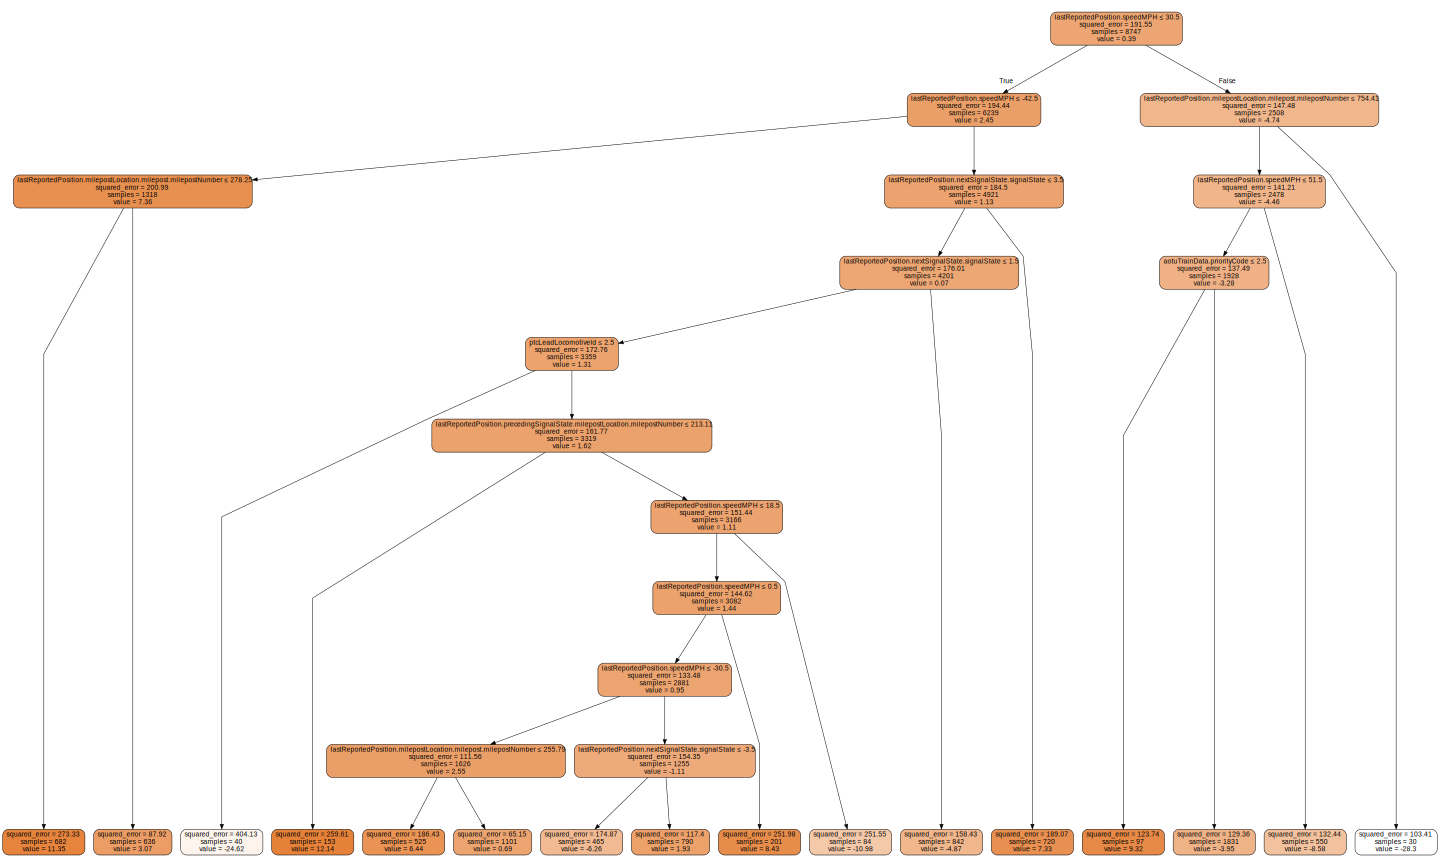

In [43]:
fastai.draw_tree(m, xs, size=20, leaves_parallel=True, precision=2)

In [44]:
m = DecisionTreeRegressor(min_samples_leaf=10)
m.fit(xs, y);

In [45]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [46]:
m_rmse(m, xs, y)

7.900618

In [47]:
m_rmse(m, valid_xs, valid_y)

14.623485

In [48]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [49]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
33,lastReportedPosition.speedMPH,0.228827
34,lastReportedPosition.milepostLocation.milepost.milepostNumber,0.209671
59,lastReportedPosition.positionTimeElapsed,0.119081
51,lastReportedPosition.nextSignalState.signalState,0.083647
52,milepost,0.043016
0,ptcLeadLocomotiveId,0.037739
47,lastReportedPosition.precedingSignalState.milepostLocation.milepostNumber,0.034258
31,trainLength,0.029340
3,trainId.trainSymbol,0.024447
29,loadedCarCount,0.020759


Our first result! It appears the previous speed is so heavily influencing the next speed, it swamps everything else.

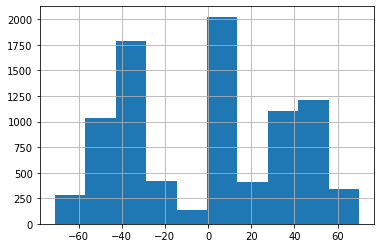

In [50]:
ax = xs['lastReportedPosition.speedMPH'].hist()


This is sort of a dur moment, saying "Speeds don't change a lot one milepost to the next".  

#Random Forest

In [61]:
def randomForest(xs, y, n_estimators=50, max_samples=8000,
       max_features=0.6, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [62]:
m = randomForest(xs, y);

In [63]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(6.182213, 10.771608)

RandomForestRegressor(max_features=0.6, max_samples=8000, min_samples_leaf=5,
                      n_estimators=50, n_jobs=-1, oob_score=True)

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [66]:
r_mse(preds.mean(0), valid_y)

10.771608

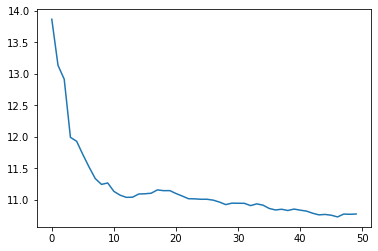

In [68]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(50)]);

### Out-of-Bag Error

In [ ]:
r_mse(m.oob_prediction_, y)

10.355091

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?


In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [ ]:
preds.shape

(50, 844)

In [ ]:
preds_std = preds.std(0)

In [74]:
print(preds.mean(0)[:15])
print(valid_y[:15])

[  1.25783936  -9.37539189 -12.23460279 -13.21507249 -12.80728714  -9.06190632  -4.34928377  -3.88733933  -2.761887    -3.85866767  -4.45679639  -8.25154235  -8.81638695  -9.01038695  -9.66000672]
5127    -1
5128    -8
5129   -11
5130   -11
5131    -8
5132     3
5133    16
5134    16
5135    12
5136     9
5137     6
5138     1
5139     0
5140     0
5141    -2
Name: nextSpeed, dtype: int8


# FEATURE Importance

In [ ]:
fi = rf_feat_importance(m, xs)
fi[:20]

,cols,imp
30,lastReportedPosition.speedMPH,0.237157
32,lastReportedPosition.milepostLocation.milepost.milepostNumber,0.133006
52,milepost,0.078834
59,lastReportedPosition.positionTimeElapsed,0.063294
47,lastReportedPosition.precedingSignalState.milepostLocation.milepostNumber,0.055240
51,lastReportedPosition.nextSignalState.signalState,0.053672
50,lastReportedPosition.nextSignalState.milepostLocation.milepostNumber,0.042685
0,ptcLeadLocomotiveId,0.030435
3,trainId.trainSymbol,0.026138
28,trainLength,0.024713


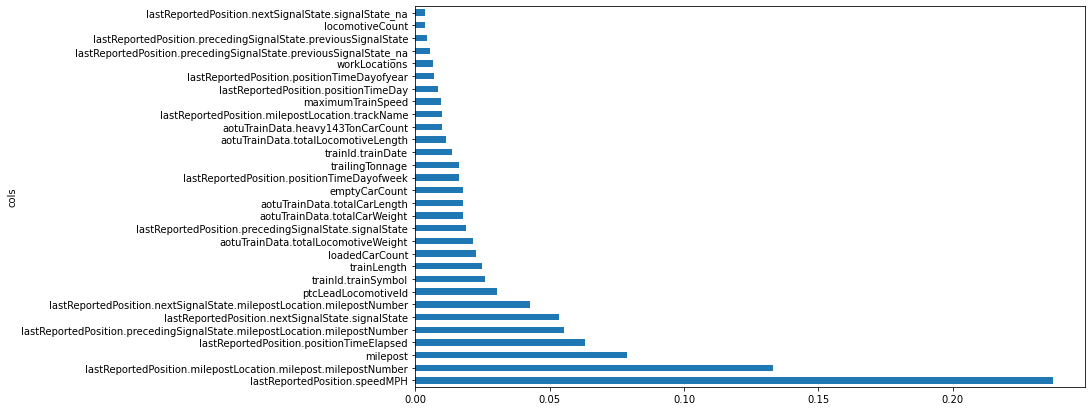

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

Remove low importance columns

In [ ]:
to_keep = fi[fi.imp>0.0002].cols
len(to_keep)

37

In [ ]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [ ]:
m = randomForest(xs_imp, y)

In [ ]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(9.620474, 10.926534)

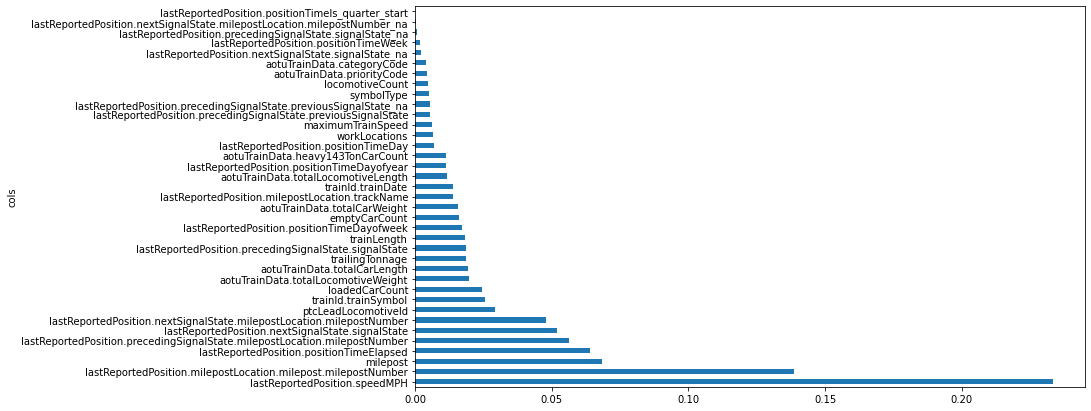

In [ ]:
plot_fi(rf_feat_importance(m, xs_imp));

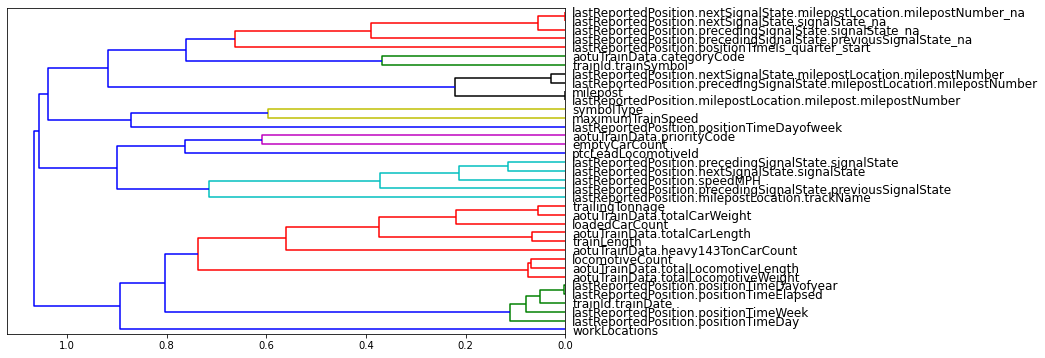

In [ ]:
fastai.cluster_columns(xs_imp)